In [1]:
import zipfile 
z = zipfile.ZipFile("archive.zip")
z.extractall()

In [2]:
import os,shutil
import random
import numpy as np
import pandas as pd 
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [3]:
labels = ['PNEUMONIA','NORMAL']
img_size = 128
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr,(img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return data

In [4]:
train = get_data("chest_xray/chest_xray/train")
test = get_data("chest_xray/chest_xray/test")
val = get_data("chest_xray/chest_xray/val")

OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [5]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

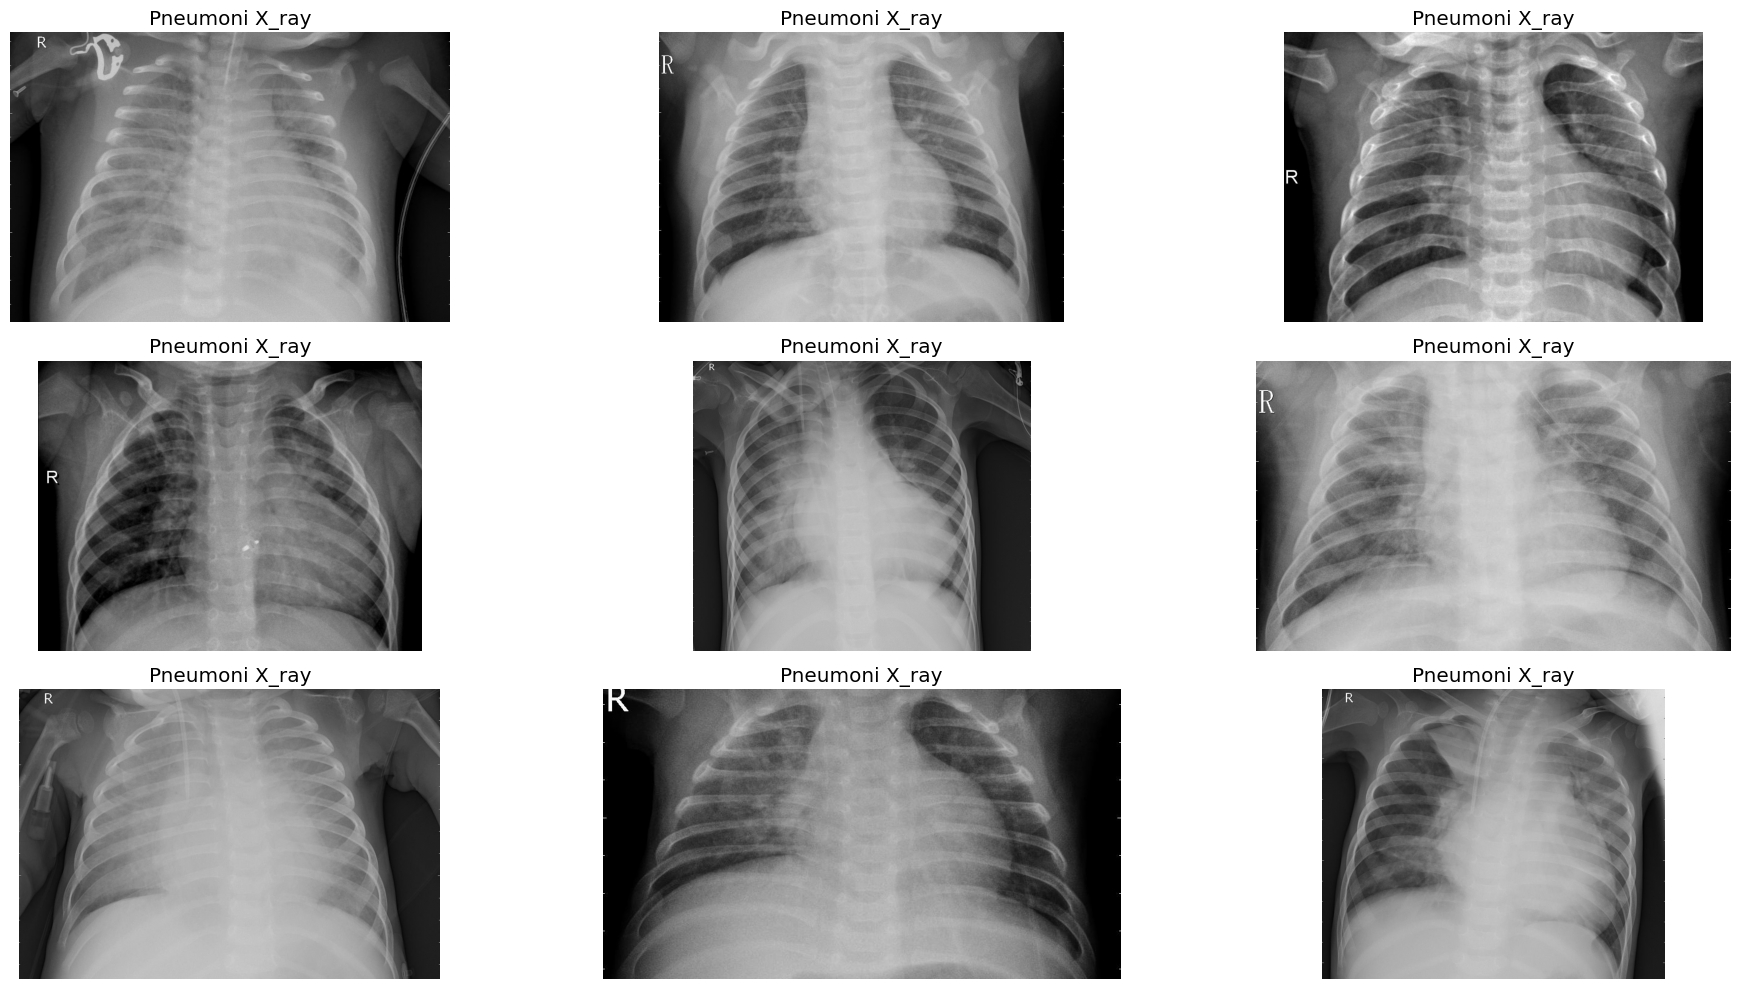

In [6]:
plt.figure(figsize = (20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap = 'gray')
    plt.axis("off")
    plt.title("Pneumoni X_ray")
plt.tight_layout() 

In [7]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

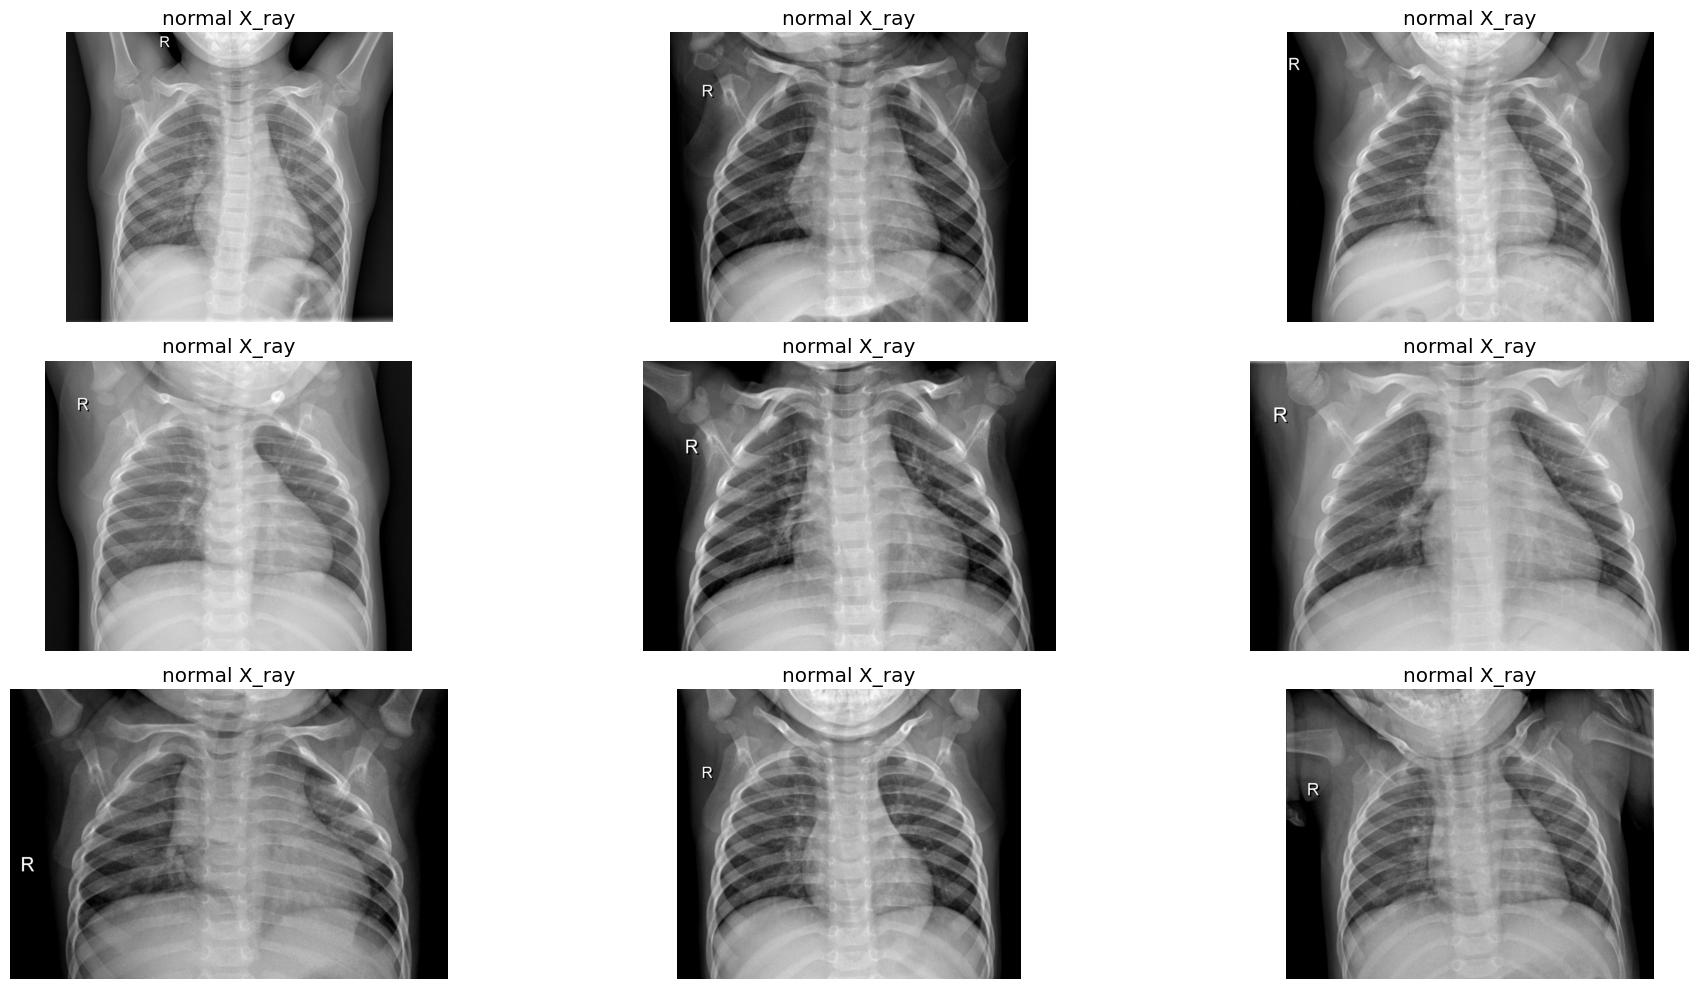

In [8]:
plt.figure(figsize = (20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir, normal[i]))
    plt.imshow(img, cmap = 'gray')
    plt.axis("off")
    plt.title("normal X_ray")
plt.tight_layout() 

<Axes: xlabel='count'>

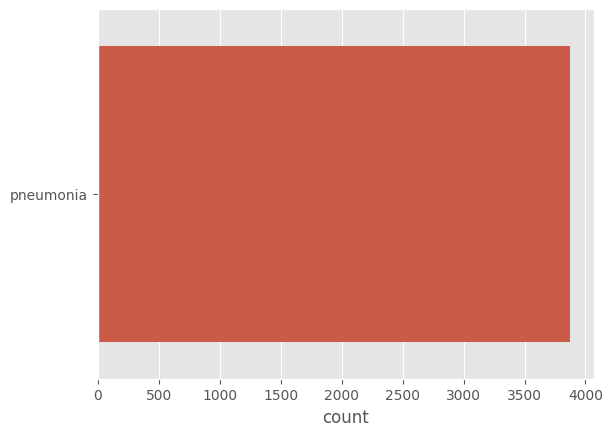

In [9]:
listx = []
for i in train:
    if(i[1] == 0):
        listx.append("pneumonia")
    else:
        listx.append("normal")
sns.countplot(listx)

In [10]:
# Data Agumentation & Resizing 

In [52]:
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array  
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [12]:
train_datagen = ImageDataGenerator(rescale = 1. / 255,
                  horizontal_flip = 0.4,
                  vertical_flip = 0.4,
                  rotation_range = 40,
                  shear_range = 0.2,
                  width_shift_range = 0.4,
                  height_shift_range = 0.4,
                  fill_mode = "nearest")
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
train_generator = train_datagen.flow_from_directory("chest_xray/chest_xray/train",
                                 batch_size = 32,
                                 target_size = (128,128),
                                 class_mode = 'categorical',
                                 shuffle = True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("chest_xray/chest_xray/val",
                                 batch_size = 32,
                                 target_size = (128,128),
                                 class_mode = 'categorical',
                                 shuffle = True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [14]:
class_labels = train_generator.class_indices

In [15]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [16]:
class_name = {value:key for (key, value) in class_labels.items()}

In [17]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [18]:
#VGG19 CNN Architecture

In [19]:
base_model = VGG19(input_shape = (128, 128, 3),
                     include_top = False,
                     weights = 'imagenet')
for layer in base_model.layers:
    layer.trainable = False
    
x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.inputs, output)
model_01.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [20]:
filepath = "model.h5"
es = EarlyStopping(monitor ="val_loss", verbose=1, mode="min", patience=4)
cp=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, verbose=1, factor=0.5, min_lr=0.0001)

sgd = SGD(learning_rate = 0.0001, decay = 1e-6, momentum = 0.0, nesterov = True)

model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

c:\Users\Admin\Desktop\final project\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [21]:
history_01 = model_01.fit(train_generator,
            steps_per_epoch=50,
            epochs=20,
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

c:\Users\Admin\Desktop\final project\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6633 - loss: 0.6334

50/50 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.6644 - loss: 0.6326 - val_accuracy: 0.5000 - val_loss: 0.9143 - learning_rate: 1.0000e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7544 - loss: 0.5553 - val_accuracy: 0.5000 - val_loss: 0.9313 - learning_rate: 1.0000e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7275 - loss: 0.5845 - val_accuracy: 0.5000 - val_loss: 0.9755 - learning_rate: 1.0000e-04
Epoch 4/20
13/50 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7627 - loss: 0.5379

c:\Users\Admin\Desktop\final project\.venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 328ms/step - accuracy: 0.7498 - loss: 0.5531 - val_accuracy: 0.5000 - val_loss: 0.8955 - learning_rate: 1.0000e-04
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7514 - loss: 0.5399

50/50 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7512 - loss: 0.5401 - val_accuracy: 0.5000 - val_loss: 0.8110 - learning_rate: 1.0000e-04
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7287 - loss: 0.5512

50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7286 - loss: 0.5512 - val_accuracy: 0.5000 - val_loss: 0.8028 - learning_rate: 1.0000e-04
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7480 - loss: 0.5323 - val_accuracy: 0.5000 - val_loss: 0.8047 - learning_rate: 1.0000e-04
Epoch 8/20
13/50 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.6816 - loss: 0.5934

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 328ms/step - accuracy: 0.7109 - loss: 0.5576 - val_accuracy: 0.5000 - val_loss: 0.7895 - learning_rate: 1.0000e-04
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7632 - loss: 0.4945 - val_accuracy: 0.5000 - val_loss: 0.7981 - learning_rate: 1.0000e-04
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7540 - loss: 0.4967 - val_accuracy: 0.5000 - val_loss: 0.8110 - learning_rate: 1.0000e-04
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7615 - loss: 0.4905

50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7613 - loss: 0.4907 - val_accuracy: 0.5000 - val_loss: 0.7425 - learning_rate: 1.0000e-04
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 326ms/step - accuracy: 0.7657 - loss: 0.4795 - val_accuracy: 0.5000 - val_loss: 0.7788 - learning_rate: 1.0000e-04
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7401 - loss: 0.4949

50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.7402 - loss: 0.4948 - val_accuracy: 0.5000 - val_loss: 0.7188 - learning_rate: 1.0000e-04
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7618 - loss: 0.4862

50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7618 - loss: 0.4862 - val_accuracy: 0.5000 - val_loss: 0.7143 - learning_rate: 1.0000e-04
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.7589 - loss: 0.4797 - val_accuracy: 0.5000 - val_loss: 0.7435 - learning_rate: 1.0000e-04
Epoch 16/20
13/50 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7702 - loss: 0.4529

50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 354ms/step - accuracy: 0.7553 - loss: 0.4696 - val_accuracy: 0.5000 - val_loss: 0.7061 - learning_rate: 1.0000e-04
Epoch 17/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7547 - loss: 0.4758 - val_accuracy: 0.5000 - val_loss: 0.7614 - learning_rate: 1.0000e-04
Epoch 18/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7616 - loss: 0.4674 - val_accuracy: 0.5000 - val_loss: 0.7380 - learning_rate: 1.0000e-04
Epoch 19/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7633 - loss: 0.4461

50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7633 - loss: 0.4463 - val_accuracy: 0.5000 - val_loss: 0.6832 - learning_rate: 1.0000e-04
Epoch 20/20
13/50 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8125 - loss: 0.4296

50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 408ms/step - accuracy: 0.7805 - loss: 0.4611 - val_accuracy: 0.5000 - val_loss: 0.6609 - learning_rate: 1.0000e-04


In [22]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_01.save(filepath = "model_weights/vgg19_model_01.h5", overwrite=True)

In [23]:
test_generator = test_datagen.flow_from_directory("chest_xray/chest_xray/test",
                                 batch_size = 32,
                                 target_size = (128,128),
                                 class_mode = 'categorical',
                                 shuffle = True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 624 images belonging to 2 classes.


In [24]:
model_01.load_weights("model_weights/vgg19_model_01.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step - accuracy: 0.5000 - loss: 0.6609
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6598 - loss: 0.5748


In [25]:
print(f"Validation Loss:{vgg_val_eval_01[0]}")
print(f"Validation Accuarcy:{vgg_val_eval_01[1]}")
print(f"Test Loss:{vgg_val_eval_01[0]}")
print(f"Test Accuarcy:{vgg_val_eval_01[1]}")

Validation Loss:0.6608962416648865
Validation Accuarcy:0.5
Test Loss:0.6608962416648865
Test Accuarcy:0.5


In [26]:
#Increamental unfreezing & fine tuning

In [27]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))
base_model_layer_names = [layer.name for layer in base_model.layers]

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_02 =Model(base_model.inputs, output)
model_02.load_weights("model_weights/vgg19_model_01.h5")

set_trainable = False
for layer in base_model.layers:
    if layer.name in [ 'block5_conv3','block5_conv4']:
        set_trainable=True
    if set_trainable:
        set_trainable=True
    else:
        set_trainable=False
print(model_02.summary())    

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [28]:
base_model_layer_names

['input_layer_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [29]:
sgd = SGD(learning_rate = 0.0001, decay =1e-6, momentum=0.0, nesterov = True)

model_02.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [31]:
history_02 = model_02.fit(train_generator,
            steps_per_epoch=10,
            epochs=20,
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.8355 - loss: 0.3936 - val_accuracy: 0.5625 - val_loss: 0.6881 - learning_rate: 1.0000e-04
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.8049 - loss: 0.4211 - val_accuracy: 0.5625 - val_loss: 0.6612 - learning_rate: 1.0000e-04
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.7408 - loss: 0.4739 - val_accuracy: 0.5625 - val_loss: 0.6988 - learning_rate: 1.0000e-04
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.8308 - loss: 0.3653 - val_accuracy: 0.5625 - val_loss: 0.6665 - learning_rate: 1.0000e-04
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7785 - loss: 0.4091

10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.7767 - loss: 0.4120 - val_accuracy: 0.6250 - val_loss: 0.6458 - learning_rate: 1.0000e-04
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.8076 - loss: 0.4136 - val_accuracy: 0.6250 - val_loss: 0.6493 - learning_rate: 1.0000e-04
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8246 - loss: 0.3848

10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8235 - loss: 0.3856 - val_accuracy: 0.6250 - val_loss: 0.6109 - learning_rate: 1.0000e-04
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8182 - loss: 0.4204 - val_accuracy: 0.6250 - val_loss: 0.6368 - learning_rate: 1.0000e-04
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8149 - loss: 0.4067 - val_accuracy: 0.5625 - val_loss: 0.6914 - learning_rate: 1.0000e-04
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8141 - loss: 0.3917

10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8126 - loss: 0.3931 - val_accuracy: 0.6250 - val_loss: 0.6103 - learning_rate: 1.0000e-04
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.8134 - loss: 0.3979 - val_accuracy: 0.6250 - val_loss: 0.6130 - learning_rate: 1.0000e-04
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8294 - loss: 0.3718 - val_accuracy: 0.6250 - val_loss: 0.6282 - learning_rate: 1.0000e-04
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.7897 - loss: 0.4219 - val_accuracy: 0.6250 - val_loss: 0.6161 - learning_rate: 1.0000e-04
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.8338 - loss: 0.3678 - val_accuracy: 0.6250 - val_loss: 0.6106 - learning_rate: 1.0000e-04
Epoch 14: early stopping


In [32]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_01.save(filepath = "model_weights/vgg19_model_02.h5", overwrite=True)

In [33]:
model_02.load_weights("model_weights/vgg19_model_02.h5")

vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

print(f"Validation Loss:{vgg_val_eval_02[0]}")
print(f"Validation Accuarcy:{vgg_val_eval_02[1]}")
print(f"Test Loss:{vgg_val_eval_02[0]}")
print(f"Test Accuarcy:{vgg_val_eval_02[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step - accuracy: 0.5000 - loss: 0.6609
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.6449 - loss: 0.5902
Validation Loss:0.6608963012695312
Validation Accuarcy:0.5
Test Loss:0.6608963012695312
Test Accuarcy:0.5


In [34]:
#unfreezing and fine tuninf the entire network

In [35]:
base_model = VGG19(include_top=False, input_shape=(128,128,3))


x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

model_03 =Model(base_model.inputs, output)
model_03.load_weights("model_weights/vgg19_model_01.h5")

print(model_03.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 63,089,602 (240.67 MB)

 Non-trainable params: 0 (0.00 B)

None


In [36]:
sgd = SGD(learning_rate = 0.0001, decay =1e-6, momentum=0.0, nesterov = True)

model_03.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [37]:
history_03 = model_03.fit(train_generator,
            steps_per_epoch=100,
            epochs=20,
            callbacks=[es, cp, lrr],
            validation_data=valid_generator)

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7790 - loss: 0.4481

100/100 ━━━━━━━━━━━━━━━━━━━━ 387s 4s/step - accuracy: 0.7792 - loss: 0.4480 - val_accuracy: 0.6250 - val_loss: 0.6001 - learning_rate: 1.0000e-04
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.8063 - loss: 0.4110 - val_accuracy: 0.6250 - val_loss: 0.6080 - learning_rate: 1.0000e-04
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 386s 4s/step - accuracy: 0.8233 - loss: 0.3896 - val_accuracy: 0.6250 - val_loss: 0.6673 - learning_rate: 1.0000e-04
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.8411 - loss: 0.3473 - val_accuracy: 0.6875 - val_loss: 0.6275 - learning_rate: 1.0000e-04
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - accuracy: 0.8374 - loss: 0.3453 - val_accuracy: 0.7500 - val_loss: 0.6149 - learning_rate: 1.0000e-04
Epoch 5: early stopping


In [38]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_01.save(filepath = "model_weights/vgg_unfrozen.h5", overwrite=True)

In [39]:
model_03.load_weights("model_weights/vgg19_model_02.h5")

vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

print(f"Validation Loss:{vgg_val_eval_03[0]}")
print(f"Validation Accuarcy:{vgg_val_eval_03[1]}")
print(f"Test Loss:{vgg_val_eval_03[0]}")
print(f"Test Accuarcy:{vgg_val_eval_03[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step - accuracy: 0.5000 - loss: 0.6609
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6714 - loss: 0.5741
Validation Loss:0.6608962416648865
Validation Accuarcy:0.5
Test Loss:0.6608962416648865
Test Accuarcy:0.5


In [2]:
#Predications
from tensorflow.keras.models import load_model

model = load_model("model.h5")



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step
Prediction: Pneumonia (Confidence: 82.91%)


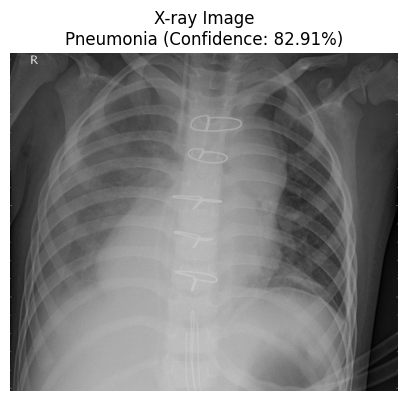

In [5]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import cv2
import matplotlib.pyplot as plt

def preprocess_image(img_path, target_size=(128, 128)):
    """
    Preprocess the image for model prediction
    """
    try:
        # Read image
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Could not read image at {img_path}")
        
        # Convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Store original image for display
        original_img = img.copy()
        
        # Resize
        img = cv2.resize(img, target_size)
        
        # Normalize
        img = img.astype(np.float32) / 255.0
        
        # Add batch dimension
        img = np.expand_dims(img, axis=0)
        
        return img, original_img
    except Exception as e:
        print(f"Error preprocessing image: {str(e)}")
        return None, None

def predict_pneumonia(model_path, image_path, confidence_threshold=0.5):
    """
    Predict pneumonia from X-ray image with improved accuracy
    """
    try:
        # Load model
        model = load_model(model_path)
        
        # Preprocess image
        processed_img, original_img = preprocess_image(image_path)
        if processed_img is None:
            return "Error processing image", None
        
        # Make prediction
        prediction = model.predict(processed_img)
        
        # Get confidence scores
        normal_conf = prediction[0][0]
        pneumonia_conf = prediction[0][1]
        
        # Apply confidence threshold
        if pneumonia_conf > confidence_threshold:
            result = f"Pneumonia (Confidence: {pneumonia_conf:.2%})"
        elif normal_conf > confidence_threshold:
            result = f"Normal (Confidence: {normal_conf:.2%})"
        else:
            result = "Uncertain - Please consult a medical professional"
            
        return result, original_img
            
    except Exception as e:
        return f"Error during prediction: {str(e)}", None

if __name__ == "__main__":
    # Example usage
    model_path = "model.h5"
    image_path = "person1_virus_7.jpeg"  # Replace with your image path
    
    result, img = predict_pneumonia(model_path, image_path)
    print(f"Prediction: {result}")
    
    # Display the image
    if img is not None:
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"X-ray Image\n{result}")
        plt.axis('off')
        plt.show()